In [251]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib

# Matrix Factorization Code from Set 5

Y_train = np.loadtxt('train.txt').astype(int)
Y_test = np.loadtxt('test.txt').astype(int)
mu = np.mean(Y_train)

In [239]:
def grad_U(Ui, Yij, Vj, reg, eta, Ai, Bj, bias):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    if bias == False:
        Ai = 0
        Bj = 0
    
    
    return eta*(reg*Ui - np.dot(Vj, (Yij - np.dot(Ui, Vj) + Ai + Bj)))

def grad_V(Vj, Yij, Ui, reg, eta, Ai, Bj, bias):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    if bias == False:
        Ai = 0
        Bj = 0
        
    return eta*(reg*Vj - np.dot(Ui,(Yij - np.dot(Ui, Vj) + Ai + Bj)))

def grad_A(Vj, Yij, Ui, reg, eta, Ai, Bj):

    return eta*(reg*Ai - (Yij - (np.dot(Ui,Vj) + Ai + Bj)))

def grad_B(Vj, Yij, Ui, reg, eta, Ai, Bj):

    return eta*(reg*Bj - (Yij - (np.dot(Ui,Vj) + Ai + Bj)))

def get_err(U, V, Y, A, B, bias, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    if bias: 
        first_term = 0.5*reg*(np.linalg.norm(U, ord='fro')**2 + np.linalg.norm(V, ord='fro')**2 + np.linalg.norm(A)**2 + np.linalg.norm(B)**2)
        second_term = 0
        for index in range(len(Y)):
            (i, j, Yij) = Y[index]
            second_term += (0.5 * (Yij - (np.dot(U[i - 1], V[j - 1])) + A[i-1] + B[j-1])**2)
        return (first_term + second_term)/len(Y)
    
    else:
        first_term = 0.5*reg*(np.linalg.norm(U, ord='fro')**2 + np.linalg.norm(V, ord='fro')**2)
        second_term = 0
        for index in range(len(Y)):
            (i, j, Yij) = Y[index]
            second_term += (0.5 * (Yij - (np.dot(U[i - 1], V[j - 1]))))
        return (first_term + second_term)/len(Y)


def get_err_bias(U, V, Y, A, B, bias, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """

    first_term = 0.5*reg*(np.linalg.norm(U, ord='fro')**2 + np.linalg.norm(V, ord='fro')**2)
    second_term = 0
    for index in range(len(Y)):
        (i, j, Yij) = Y[index]
        second_term += (0.5 * (Yij - (np.dot(U[i - 1], V[j - 1])) + A[i-1] + B[j-1])**2)
    return (first_term + second_term)/len(Y)



def train_model(M, N, K, eta, reg, Y, bias, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    
    A = np.random.uniform(-0.5, 0.5, size = (M, ))
    B = np.random.uniform(-0.5, 0.5, size = (N, ))
        
    U = np.random.uniform(-0.5, 0.5, size = (M, K))
    V = np.random.uniform(-0.5, 0.5, size = (N, K))
    
    
    MSE_before = get_err_bias(U, V, Y, A, B, bias, reg)
    for epoch in range(max_epochs):
        #print(epoch)
        #print(MSE_before)
        
#         print("U:", U[0,:])
#         print("V:", V[0,:])
        np.random.shuffle(Y)
        for index in range(len(Y)):
            (i, j, Yij) = Y[index]
            # Updates with gradient descent
            u_grad = grad_U(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[i-1], bias)
            v_grad = grad_V(V[j-1], Yij, U[i-1], reg, eta, A[i-1], B[i-1], bias)
            a_grad = grad_A(V[j-1], Yij, U[i-1], reg, eta, A[i-1], B[j-1])
            b_grad = grad_B(V[j-1], Yij, U[i-1], reg, eta, A[i-1], B[j-1])
            A[i - 1] = A[i - 1] - a_grad
            B[j - 1] = B[j - 1] - b_grad
            U[i - 1] = U[i-1] - u_grad
            V[j - 1] = V[j-1] - v_grad
        #print(A[0:3], B[0:3])
            
        MSE_after = get_err(U, V, Y, A, B, bias, reg)
        difference = MSE_before - MSE_after
        if epoch == 0:
            epoch1_MSE_diff = difference
        if difference/epoch1_MSE_diff <= eps:
            break
        MSE_before = MSE_after

    return U, V, MSE_before, A, B


In [170]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies



#U,V, err = train_model(M, N, K, eta, reg, Y_train)



#Ks = [10,20,30,50,100]
#Ks = [20]
k = 20
#regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
regs = [0.1]
etas = [0.01]
#etas = [0.03, 0.01, 0.003, 0.001, 0.0003]  # learning rate
#E_ins = []
#E_outs = []

bias = True
# Use to compute Ein and Eout
for reg in regs:
    #E_ins_for_lambda = []
    #E_outs_for_lambda = []

    for eta in etas:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, k, eta, reg))
        U,V, e_in, A, B = train_model(M, N, k, eta, reg, Y_train, bias)
        #E_ins_for_lambda.append(e_in)
        eout = get_err(U, V, Y_test, A,B, bias)
        #E_outs_for_lambda.append(eout)

    #E_ins.append(E_ins_for_lambda)
    #E_outs.append(E_outs_for_lambda)
    



Training model with M = 943, N = 1682, k = 20, eta = 0.01, reg = 0.1


In [244]:
#get_err(np.transpose(U), np.transpose(V), Y_test, A, B, True, 0.1)

0.4838640689414741

In [175]:
print(np.shape(U))
print(np.shape(V))

print(np.shape(A))

(20, 943)
(20, 1682)
(943,)


In [172]:
U = np.transpose(U)
V = np.transpose(V)

In [178]:
res = np.matmul(np.transpose(U), V)

A_matrix = np.array([A for i in range(N)])
A_matrix = A_matrix.T
B_matrix = np.array([B for i in range(M)])


print(np.shape(A_matrix))
print(np.shape(B_matrix))

res = res + A_matrix + B_matrix

(943, 1682)
(943, 1682)


In [250]:
print(res[771][312])
print(Y_test[2])


# print(np.shape(U), (np.shape(V)))

# print(res)
# print(np.min(res))

# print(res < 1)
# print(np.sum(res < 1))
# print(np.shape(res))

#print(E_ins, E_outs)


4.62616136409459
[772 313   5]


In [181]:
A1,S,B1 = np.linalg.svd(V)

In [183]:
print(S)
#print(np.shape(A))

U_tilde = np.matmul(np.transpose(A1)[0:2, :], U)
V_tilde = np.matmul(np.transpose(A1)[0:2, :], V)

print(np.shape(U_tilde))
print(np.shape(V_tilde))

[65.98436896 18.13410718 12.74515856 12.40065863 11.24068986 11.02905507
 10.71098283 10.48645608 10.32876307 10.12847119  9.95621745  9.64352866
  9.44171677  9.33087909  9.08689819  8.98954173  8.77830343  8.73062458
  8.53875095  8.13807099]
(2, 943)
(2, 1682)


In [184]:
print(V_tilde)

[[ 1.96737858  1.6663133   1.64665517 ...  0.73587621  1.18373253
   1.147182  ]
 [-0.31966265 -0.47559624 -0.1965795  ... -0.010684    0.13686825
   0.25836871]]


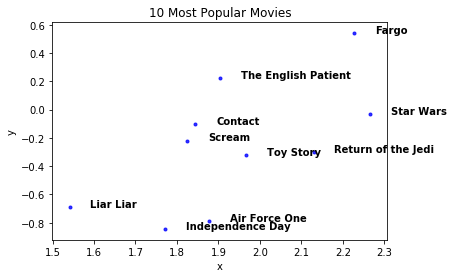

In [200]:
# 10 Most Popular Movies - SGD U and V with Biases
ten_popular_indices = np.array([50.0, 258.0, 100.0, 181.0, 294.0, 286.0, 288.0, 1.0, 300.0, 121.0]) - 1
ten_popular_indices = ten_popular_indices.astype(int)

ten_popular_movies = {0: 'Toy Story', 49 : 'Star Wars', 99 : 'Fargo', 120 : 'Independence Day', 180 : 'Return of the Jedi', 257 : 'Contact', 285 : 'The English Patient', 287 : 'Scream', 293 : 'Liar Liar', 299 : 'Air Force One'}


# x = []
# y = []
# for i in ten_popular_indices:
#     x.append(V_tilde[0][i])
#     y.append(V_tilde[1][i])


# sns.scatterplot(x, y)

    
scatter_with_labels(ten_popular_movies, V_tilde, '10 Most Popular Movies')

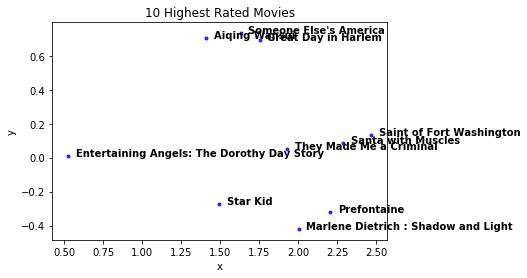

In [206]:
# 10 Highest Rated Movies - SGD U and V with Biases
ten_best_indices = [1201.0, 1122.0, 1467.0, 1653.0, 1599.0, 1293.0, 1536.0, 814.0, 1500.0, 1189.0]
ten_best_movies = {813 : 'Great Day in Harlem', 1121 : 'They Made Me a Criminal', 1188 : 'Prefontaine', 1200 : 'Marlene Dietrich : Shadow and Light', 1292 : 'Star Kid', 1466 : 'Saint of Fort Washington', 1499 : 'Santa with Muscles', 1535 : 'Aiqing Wansui', 1598 : 'Someone Else\'s America', 1653 : 'Entertaining Angels: The Dorothy Day Story'}

scatter_with_labels(ten_best_movies, V_tilde, '10 Highest Rated Movies')

In [202]:
ten_best_movies = {}

{1201.0: 0, 1122.0: 0, 1467.0: 0, 1653.0: 0, 1599.0: 0, 1293.0: 0, 1536.0: 0, 814.0: 0, 1500.0: 0, 1189.0: 0}


In [186]:
V_tilde[0][1]

1.666313304622109

The Shining


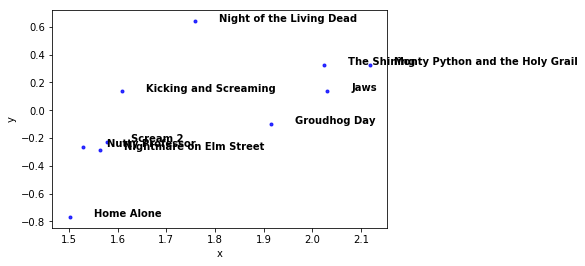

In [194]:
horror_comedy = {218: "Nightmare on Elm Street", 199: "The Shining", 233: "Jaws", 894: "Scream 2", 615: "Night of the Living Dead", 201: "Groudhog Day", 167: "Monty Python and the Holy Grail", 93: "Home Alone", 410: "Nutty Professor",694: "Kicking and Screaming" }

x = []
y = []
for i in horror_comedy.keys():
    x.append(V_tilde[0][i])
    y.append(V_tilde[1][i])
    
#print(horror_comedy.values())
    
df = pd.DataFrame({'x': x, 'y' : y, 'movie_names' : list(horror_comedy.values())})
#sns.scatterplot(x, y)

pl = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker=".", color="blue")
for line in range(0,df.shape[0]):
     pl.text(df.x[line]+0.05, df.y[line], df.movie_names[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

print(df.movie_names[1])
#print(x, y)

In [222]:
def scatter_with_labels(label_dict, V_tilde, title):
    x = []
    y = []
    for i in label_dict.keys():
        x.append(V_tilde[0][i])
        y.append(V_tilde[1][i])

    #print(horror_comedy.values())

    df = pd.DataFrame({'x': x, 'y' : y, 'movie_names' : list(label_dict.values())})
    #sns.scatterplot(x, y)
    plt.figure()
    pl = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker=".", color="blue", scatter_kws={'s':400})
    pl.set_title(title)
    for line in range(0,df.shape[0]):
         pl.text(df.x[line]+0.05, df.y[line], df.movie_names[line], horizontalalignment='left', size='medium', color='black', weight='semibold')



In [226]:
def make_all_plots(V_tilde, type_string):
    our_own_dict = {218: "Nightmare on Elm Street", 199: "The Shining", 233: "Jaws", 894: "Scream 2", 615: "Night of the Living Dead", 201: "Groudhog Day", 167: "Monty Python and the Holy Grail", 93: "Home Alone", 410: "Nutty Professor",694: "Kicking and Screaming" }
    popular_10_movies = {0: 'Toy Story', 49 : 'Star Wars', 99 : 'Fargo', 120 : 'Independence Day', 180 : 'Return of the Jedi', 257 : 'Contact', 285 : 'The English Patient', 287 : 'Scream', 293 : 'Liar Liar', 299 : 'Air Force One'}
    action = {1: 'GoldenEye (1995)', 3: 'Get Shorty (1995)', 16: 'From Dusk Till Dawn (1996)', 20: 'Muppet Treasure Island (1996)', 21: 'Braveheart (1995)', 23: 'Rumble in the Bronx (1995)', 26: 'Bad Boys (1995)', 27: 'Apollo 13 (1995)', 28: 'Batman Forever (1995)', 32: 'Desperado (1995)'}
    adventure = {34: 'Free Willy 2: The Adventure Home (1995)', 49: 'Star Wars (1977)', 61: 'Stargate (1994)', 77: 'Free Willy (1993)', 81: 'Jurassic Park (1993)', 96: 'Dances with Wolves (1990)', 100: 'Heavy Metal (1981)', 109: 'Operation Dumbo Drop (1995)', 111: 'Flipper (1996)', 116: '"Rock, The (1996)"'}
    animation = {0: 'Toy Story (1995)', 70: '"Lion King, The (1994)"', 94: 'Aladdin (1992)', 98: 'Snow White and the Seven Dwarfs (1937)', 101: '"Aristocats, The (1970)"', 102: 'All Dogs Go to Heaven 2 (1996)', 113: 'Wallace & Gromit: The Best of Aardman Animation (1996)', 168: '"Wrong Trousers, The (1993)"', 188: '"Grand Day Out, A (1992)"', 205: 'Akira (1988)'}
    ten_best_movies = {813 : 'Great Day in Harlem', 1121 : 'They Made Me a Criminal', 1188 : 'Prefontaine', 1200 : 'Marlene Dietrich : Shadow and Light', 1292 : 'Star Kid', 1466 : 'Saint of Fort Washington', 1499 : 'Santa with Muscles', 1535 : 'Aiqing Wansui', 1598 : 'Someone Else\'s America', 1653 : 'Entertaining Angels: The Dorothy Day Story'}
    
    scatter_with_labels(our_own_dict, V_tilde, "Horror and Comedy Movies " + type_string)
    scatter_with_labels(popular_10_movies, V_tilde, "10 Most Popular Movies " + type_string)
    scatter_with_labels(action, V_tilde, "Action Movies " + type_string)
    scatter_with_labels(adventure, V_tilde, "Adventure Movies " + type_string)
    scatter_with_labels(animation, V_tilde, "Animation Movies " + type_string)
    scatter_with_labels(ten_best_movies, V_tilde, "Highest Rated Movies " + type_string)

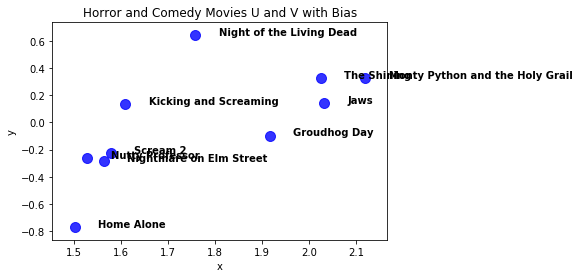

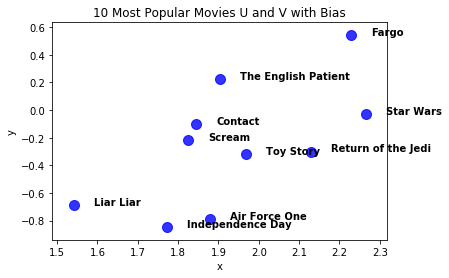

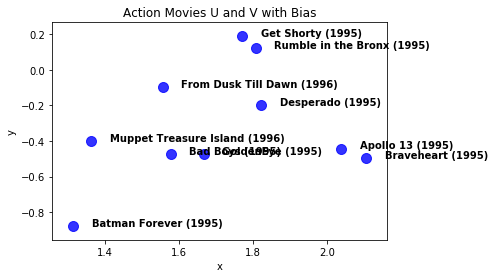

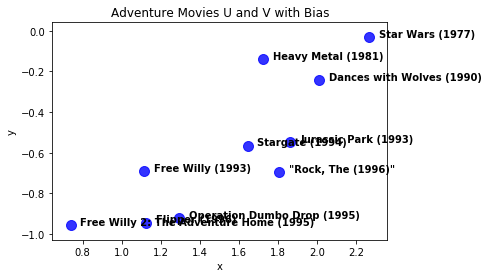

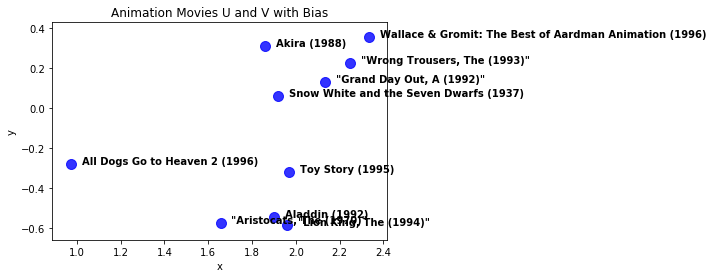

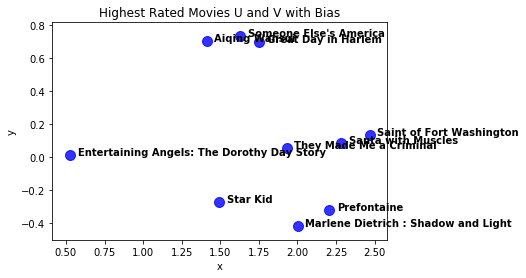

In [227]:
make_all_plots(V_tilde, 'U and V with Bias')

In [307]:
old_movies = {377: 'Miracle on 34th Street (1994)', 446: 'Carrie (1976)', 150: 'Willy Wonka and the Chocolate Factory (1971)', 201: 'Groundhog Day (1993)', 233: 'Jaws (1975)', 126: 'The Godfather (1972)',
21: 'Braveheart (1995)', 71: 'The Mask (1994)', 674 : 'Nosferatu (1922)', 133: 'Citizen Kane (1940)', 184: 'Psycho (1960)', 704 : 'Singin in the Rain (1952)', 419: 'Alice in Wonderland (1951)', 131: 'The Wizard of Oz (1939)', 
}

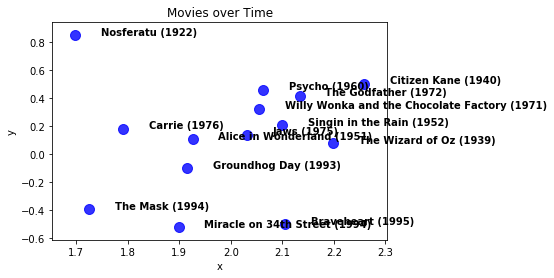

In [308]:
scatter_with_labels(old_movies, V_tilde, 'Movies over Time')

In [310]:
print(old_movies.values())

dict_values(['Miracle on 34th Street (1994)', 'Carrie (1976)', 'Willy Wonka and the Chocolate Factory (1971)', 'Groundhog Day (1993)', 'Jaws (1975)', 'The Godfather (1972)', 'Braveheart (1995)', 'The Mask (1994)', 'Nosferatu (1922)', 'Citizen Kane (1940)', 'Psycho (1960)', 'Singin in the Rain (1952)', 'Alice in Wonderland (1951)', 'The Wizard of Oz (1939)'])


In [258]:
year_dict = joblib.load('year_dict.joblib')
# Year_Dict has keys as movie ids
print(year_dict)

{1: 1995, 2: 1995, 3: 1995, 4: 1995, 5: 1995, 6: 1995, 7: 1995, 8: 1995, 9: 1995, 10: 1995, 11: 1995, 12: 1995, 13: 1995, 14: 1994, 15: 1995, 16: 1995, 17: 1996, 18: 1995, 19: 1995, 20: 1995, 21: 1996, 22: 1995, 23: 1976, 24: 1995, 25: 1996, 26: 1995, 27: 1995, 28: 1995, 29: 1995, 30: 1967, 31: 1995, 32: 1994, 33: 1995, 34: 1995, 35: 1995, 36: 1995, 37: 1994, 38: 1995, 39: 1995, 40: 1995, 41: 1995, 42: 1994, 43: 1994, 44: 1994, 45: 1994, 46: 1994, 47: 1994, 48: 1994, 49: 1994, 50: 1977, 51: 1994, 52: 1994, 53: 1994, 54: 1995, 55: 1994, 56: 1994, 57: 1994, 58: 1994, 59: 1994, 60: 1993, 61: 1994, 62: 1994, 63: 1994, 64: 1994, 65: 1993, 66: 1995, 67: 1994, 68: 1994, 69: 1994, 70: 1994, 71: 1994, 72: 1994, 73: 1994, 74: 1965, 75: 1994, 76: 1993, 77: 1993, 78: 1993, 79: 1993, 80: 1993, 81: 1994, 82: 1993, 83: 1993, 84: 1994, 85: 1994, 86: 1993, 87: 1993, 88: 1993, 89: 1982, 90: 1993, 91: 1993, 92: 1993, 93: 1995, 94: 1990, 95: 1992, 96: 1991, 97: 1990, 98: 1991, 99: 1937, 100: 1996, 101: 19

In [259]:
year_dict

{1: 1995,
 2: 1995,
 3: 1995,
 4: 1995,
 5: 1995,
 6: 1995,
 7: 1995,
 8: 1995,
 9: 1995,
 10: 1995,
 11: 1995,
 12: 1995,
 13: 1995,
 14: 1994,
 15: 1995,
 16: 1995,
 17: 1996,
 18: 1995,
 19: 1995,
 20: 1995,
 21: 1996,
 22: 1995,
 23: 1976,
 24: 1995,
 25: 1996,
 26: 1995,
 27: 1995,
 28: 1995,
 29: 1995,
 30: 1967,
 31: 1995,
 32: 1994,
 33: 1995,
 34: 1995,
 35: 1995,
 36: 1995,
 37: 1994,
 38: 1995,
 39: 1995,
 40: 1995,
 41: 1995,
 42: 1994,
 43: 1994,
 44: 1994,
 45: 1994,
 46: 1994,
 47: 1994,
 48: 1994,
 49: 1994,
 50: 1977,
 51: 1994,
 52: 1994,
 53: 1994,
 54: 1995,
 55: 1994,
 56: 1994,
 57: 1994,
 58: 1994,
 59: 1994,
 60: 1993,
 61: 1994,
 62: 1994,
 63: 1994,
 64: 1994,
 65: 1993,
 66: 1995,
 67: 1994,
 68: 1994,
 69: 1994,
 70: 1994,
 71: 1994,
 72: 1994,
 73: 1994,
 74: 1965,
 75: 1994,
 76: 1993,
 77: 1993,
 78: 1993,
 79: 1993,
 80: 1993,
 81: 1994,
 82: 1993,
 83: 1993,
 84: 1994,
 85: 1994,
 86: 1993,
 87: 1993,
 88: 1993,
 89: 1982,
 90: 1993,
 91: 1993,
 92: 199

In [299]:
before_1990 = []
for i in range(len(year_dict)):
    if year_dict[i+1] < 1990:
        before_1990.append(i)
x, y, z = V_tilde[0, before_1990], V_tilde[1, before_1990], [year_dict[i+1] for i in before_1990]


In [302]:
after_1990 = []
for i in range(len(year_dict)):
    if year_dict[i+1] >= 1990:
        after_1990.append(i)
x, y, z = V_tilde[0, after_1990], V_tilde[1, after_1990], [year_dict[i+1] for i in after_1990]

In [293]:
x, y, z = V_tilde[0, :], V_tilde[1, :], [year_dict[i] for i in year_dict]

Text(0,0.5,'Component 2')

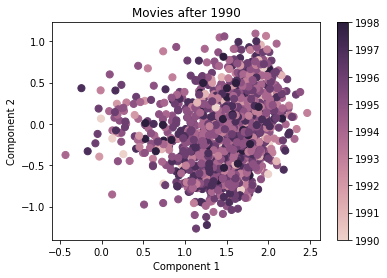

In [303]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(x, y, c=z, s=50, cmap=cmap)
f.colorbar(points)
plt.title('Movies after 1990')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

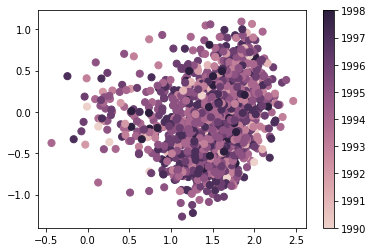

In [282]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(x, y, c=z, s=50, cmap=cmap)
f.colorbar(points)


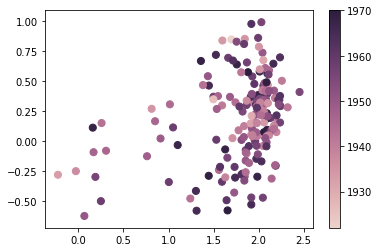

In [284]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(x, y, c=z, s=50, cmap=cmap)
f.colorbar(points)



In [291]:
after_1980 = []
for i in range(len(year_dict)):
    if year_dict[i+1] >= 1990:
        after_1980.append(i)
x, y, z = V_tilde[0, after_1980], V_tilde[1, after_1980], [year_dict[i+1] for i in after_1980]

Text(0,0.5,'Component 2')

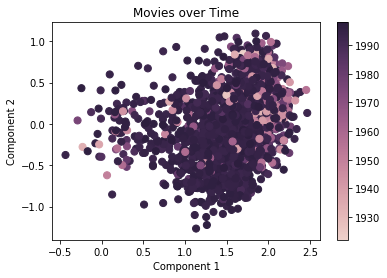

In [298]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(x, y, c=z, s=50, cmap=cmap)
f.colorbar(points)
plt.title('Movies over Time')
plt.xlabel('Component 1')
plt.ylabel('Component 2')


In [347]:
data = np.loadtxt('data.txt')
ratings = np.array(data[:, 2])

#decades = {1920 : [], 1930 : [], 1940 : [], 1950 : [], 1960 : [], 1970 : [], 1980 : [], 1990 : []}

decades = {1980 : [], 1990 : []}
# for i in range(len(year_dict)):
#     for j in range(1920, 2000, 10):
#         if year_dict[i + 1] >= j and year_dict[i + 1] < (j + 10):
#             decades[j].append(ratings[i])

for i in range(len(year_dict)):
    if year_dict[i + 1] < 1990:
        decades[1980].append(ratings[i])
    else:
        decades[1990].append(ratings[i])
    
for i in decades.keys():
    decades[i] = np.array(decades[i])
        


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


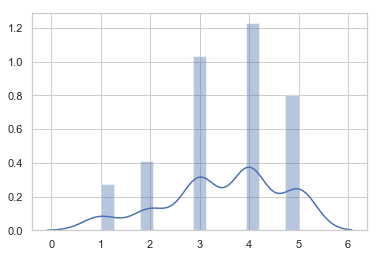

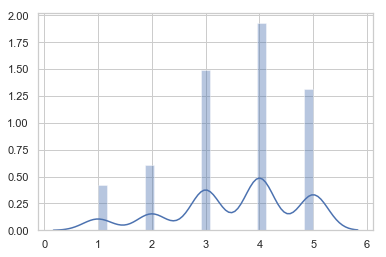

In [353]:
for i in decades.keys():
    plt.figure()
    sns.distplot(decades[i])

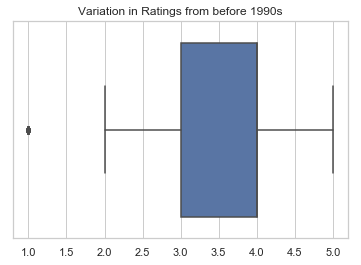

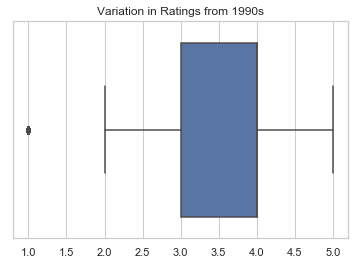

In [348]:
for i in decades.keys():
    plt.figure()
    sns.set(style="whitegrid")
    ax = sns.boxplot(decades[i])
    if i == 1980:
        ttl = 'Variation in Ratings from before 1990s'
    else:
        ttl = 'Variation in Ratings from 1990s'
    plt.title(ttl)  

In [340]:
for i in decades_averages.keys():
    decades_averages[i] = sum(decades[i])/len(decades[i])



In [341]:
print(decades_averages)

{}
